# Loading Data

In [1]:
import pickle

In [2]:
import numpy as np

In [3]:
with open('train_qa.txt','rb') as f:
    train_data = pickle.load(f)

In [4]:
with open('test_qa.txt','rb') as f:
    test_data = pickle.load(f)

In [10]:
type(test_data[0][0])

list

# EXPLORE THE DATA

In [11]:
len(test_data)

1000

In [12]:
len(train_data)

10000

In [16]:
' '.join(train_data[0][0])

'Mary moved to the bathroom . Sandra journeyed to the bedroom .'

In [20]:
' '.join(train_data[0][1])

'Is Sandra in the hallway ?'

In [21]:
' '.join(train_data[0][2])

'n o'

# Setting up Vocabulary of all work

In [23]:
vocab = set()

In [24]:
all_data = test_data+train_data

In [27]:
len(all_data)

11000

In [28]:
for s,q,a in all_data:
    vocab = vocab.union(set(s))
    vocab = vocab.union(set(q))

In [29]:
vocab.add('no')
vocab.add('yes')

In [31]:
vocab_len = len(vocab) + 1

In [32]:
vocab_len

38

In [36]:
max_story_len = max([len(data[0]) for data in all_data])

In [38]:
max_story_len

156

In [39]:
max_question_len = max([len(data[1]) for data in all_data])

In [40]:
max_question_len

6

# Vectorizing Data:

In [41]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [42]:
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

In [43]:
tokenizer.word_index

{'took': 1,
 'the': 2,
 'hallway': 3,
 'football': 4,
 'garden': 5,
 'apple': 6,
 'back': 7,
 'grabbed': 8,
 'there': 9,
 'office': 10,
 'discarded': 11,
 'left': 12,
 'mary': 13,
 'is': 14,
 'down': 15,
 '.': 16,
 'went': 17,
 'sandra': 18,
 'yes': 19,
 'picked': 20,
 'no': 21,
 'got': 22,
 'bedroom': 23,
 'daniel': 24,
 'up': 25,
 'journeyed': 26,
 'bathroom': 27,
 'in': 28,
 'john': 29,
 'put': 30,
 'moved': 31,
 'dropped': 32,
 'kitchen': 33,
 '?': 34,
 'milk': 35,
 'travelled': 36,
 'to': 37}

In [44]:
train_story_text = []
train_question_text = []
train_answers = []

for story,question,answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)

In [45]:
train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [49]:
def vectorize_stories(data, word_index=tokenizer.word_index, max_story_len=max_story_len,max_question_len=max_question_len):
    '''
    INPUT: 
    
    data: consisting of Stories,Queries,and Answers
    word_index: word index dictionary from tokenizer
    max_story_len: the length of the longest story (used for pad_sequences function)
    max_question_len: length of the longest question (used for pad_sequences function)


    OUTPUT:
    
    Vectorizes the stories,questions, and answers into padded sequences. We first loop for every story, query , and
    answer in the data. Then we convert the raw words to an word index value. Then we append each set to their appropriate
    output list. Then once we have converted the words to numbers, we pad the sequences so they are all of equal length.
    
    Returns this in the form of a tuple (X,Xq,Y) (padded based on max lengths)
    '''
    
    
    # X = STORIES
    X = []
    # Xq = QUERY/QUESTION
    Xq = []
    # Y = CORRECT ANSWER
    Y = []      
     
    for story, query, answer in data:
        
        # Grab the word index for every word in story
        x = [word_index[word.lower()] for word in story]
        # Grab the word index for every word in query
        xq = [word_index[word.lower()] for word in query]
        
        # Grab the Answers (either Yes/No so we don't need to use list comprehension here)
        # Index 0 is reserved so we're going to use + 1
        y = np.zeros(len(word_index) + 1)
        
        # Now that y is all zeros and we know its just Yes/No , we can use numpy logic to create this assignment
        #
        y[word_index[answer]] = 1
        
        # Append each set of story,query, and answer to their respective holding lists
        X.append(x)  
        Xq.append(xq)
        Y.append(y)
        
    # Finally, pad the sequences based on their max length so the RNN can be trained on uniformly long sequences.
        
    # RETURN TUPLE FOR UNPACKING
    return (pad_sequences(X, maxlen=max_story_len),pad_sequences(Xq, maxlen=max_question_len), np.array(Y))

In [50]:
inputs_train, queries_train, answers_train = vectorize_stories(train_data)

In [85]:
input_test,queries_test,answer_test = vectorize_stories(test_data)

In [59]:
sum(answer_test)

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 497.,   0., 503.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.])

In [66]:
vocab_size =len(vocab) +1

In [67]:
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))

# Creating the Model

In [82]:
from keras.models import Sequential,Model

In [69]:
from keras.layers.embeddings import Embedding

In [70]:
from keras.layers import Input,Activation,Dense,Permute,Dropout,add,dot,concatenate,LSTM

In [71]:
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,output_dim=64))
input_encoder_m.add(Dropout(0.3))

In [72]:
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))

In [73]:
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,output_dim=64,input_length=max_question_len))
question_encoder.add(Dropout(0.3))

In [74]:
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

In [75]:
match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match = Activation('softmax')(match)

In [76]:
# add the match matrix with the second input vector sequence
response = add([match, input_encoded_c])  # (samples, story_maxlen, query_maxlen)
response = Permute((2, 1))(response)  # (samples, query_maxlen, story_maxlen)

In [77]:
answer = concatenate([response, question_encoded])

In [78]:
answer

<tf.Tensor 'concatenate_1/concat:0' shape=(?, 6, 220) dtype=float32>

In [79]:
answer = LSTM(32)(answer)
answer = Dropout(0.5)(answer)
answer = Dense(vocab_size)(answer)

In [80]:
answer = Activation('softmax')(answer)

In [198]:
model = Model([input_sequence,question],answer)
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 156)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 6)            0                                            
__________________________________________________________________________________________________
sequential_5 (Sequential)       multiple             2432        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_7 (Sequential)       (None, 6, 64)        2432        input_2[0][0]                    
__________________________________________________________________________________________________
dot_1 (Dot

In [230]:
# Train
history = model.fit([inputs_train,queries_train],answers_train,batch_size=32,epochs=20,validation_data=([input_test,queries_test],answer_test))

Train on 10000 samples, validate on 1000 samples
Epoch 1/20
10000/10000 [==============================] - 7s 729us/step - loss: 2.7341 - acc: 0.5022 - val_loss: 0.7613 - val_acc: 0.6050
Epoch 2/20
10000/10000 [==============================] - 7s 650us/step - loss: 1.1280 - acc: 0.5655 - val_loss: 0.6354 - val_acc: 0.6410
Epoch 3/20
10000/10000 [==============================] - 6s 587us/step - loss: 0.9373 - acc: 0.6023 - val_loss: 0.6034 - val_acc: 0.7190
Epoch 4/20
10000/10000 [==============================] - 7s 676us/step - loss: 0.8508 - acc: 0.6444 - val_loss: 0.5408 - val_acc: 0.7560
Epoch 5/20
10000/10000 [==============================] - 7s 662us/step - loss: 0.7364 - acc: 0.6994 - val_loss: 0.4899 - val_acc: 0.7900
Epoch 6/20
10000/10000 [==============================] - 7s 707us/step - loss: 0.6551 - acc: 0.7378 - val_loss: 0.4596 - val_acc: 0.8070
Epoch 7/20
10000/10000 [==============================] - 6s 576us/step - loss: 0.5902 - acc: 0.7724 - val_loss: 0.4193 - v

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


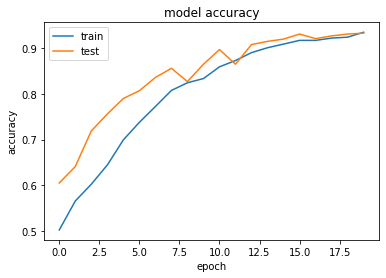

In [231]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Open Model 

In [232]:
pred_results = model.predict(([input_test,queries_test]))

In [233]:
test_data[0][0]

['Mary',
 'got',
 'the',
 'milk',
 'there',
 '.',
 'John',
 'moved',
 'to',
 'the',
 'bedroom',
 '.']

In [234]:
pred_results[0]

array([1.57666340e-14, 1.35988446e-14, 1.54475906e-14, 1.46600600e-14,
       1.48717640e-14, 1.70146608e-14, 1.80560118e-20, 1.39101580e-14,
       1.56923204e-14, 1.58483422e-14, 1.34343135e-14, 1.50014753e-14,
       1.39186504e-14, 1.37803121e-14, 1.66844230e-14, 1.44066210e-14,
       1.46770701e-14, 1.33019824e-14, 1.67880084e-14, 5.00857027e-07,
       1.48491449e-14, 9.99999523e-01, 1.35548218e-14, 1.63754542e-14,
       1.50994499e-14, 1.52664272e-14, 1.46189586e-14, 1.54871809e-14,
       1.81900817e-14, 1.49349544e-14, 1.74088869e-14, 1.52800305e-14,
       1.65940988e-14, 1.29636902e-14, 1.52892429e-14, 1.57465288e-14,
       1.70973567e-14, 1.57931207e-14], dtype=float32)

In [235]:
val_max = np.argmax(pred_results[0])

for key,val in tokenizer.word_index.items():
    if val == val_max:
        k=key
        
print('Predicted Answer: ',k)
print('Probablity of certainity was : ',pred_results[0][val_max])

Predicted Answer:  no
Probablity of certainity was :  0.9999995


# Own Story

In [236]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [237]:
# model.load_weights('chatbot_10.h5')

In [245]:
my_story = "John left the kitchen . Sandra dropped the football in the garden ."

In [246]:
my_story.split()

['John',
 'left',
 'the',
 'kitchen',
 '.',
 'Sandra',
 'dropped',
 'the',
 'football',
 'in',
 'the',
 'garden',
 '.']

In [247]:
my_ques = "Is the football in the office ?"
my_ques.split()

['Is', 'the', 'football', 'in', 'the', 'office', '?']

In [248]:
my_data = [(my_story.split(),my_ques.split(),'no')]

In [249]:
my_story,my_ques,my_ans = vectorize_stories(my_data)

In [250]:
pred_results = model.predict(([my_story,my_ques]))

In [251]:
val_max = np.argmax(pred_results[0])

for key,val in tokenizer.word_index.items():
    if val == val_max:
        k=key
        
print('Predicted Answer: ',k)
print('Probablity of certainity was : ',pred_results[0][val_max])

Predicted Answer:  no
Probablity of certainity was :  0.92227584
